In [1]:
import imageio
import random
import numpy as np
import matplotlib.pyplot as plt

from libs.util import readImg, psnr

## 1. Detect Tamper
Check Embedded Image

### 1.1 Init 

In [2]:
## User Requirerments
## Random Seed
Sd = 7

## Permutation Key
PK = 7

## Length of Embedding Codes (>=3) 
eb = 3
if eb < 3:
    raise 'eb can not be less than 3'

tp = 1

## block size = m*m
m = 4

## recovery code bit
n = 2

## Length of the Authentication Codes
t = eb-n
print("Length of the Authentication Codes, t={}".format(t))

Length of the Authentication Codes, t=1


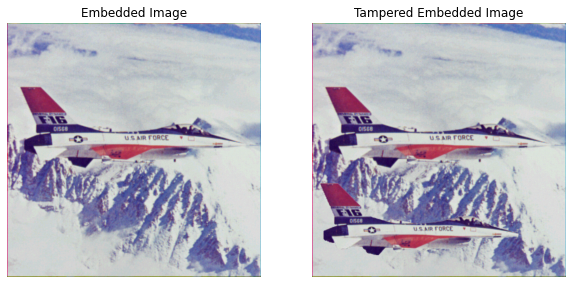

In [4]:
embedded_image = imageio.imread("./img/output/lena_embedded_eb={}.png".format(eb))

tampered_embedded_image_path = "./img/output/lena_embedded_eb={}_tp={}.png".format(eb, tp)
tampered_embedded_image = imageio.imread(tampered_embedded_image_path)
tampered_embedded_image = tampered_embedded_image[:, :, 0:3]

working_image = np.copy(tampered_embedded_image)

H, W = tampered_embedded_image.shape[:2]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(embedded_image)
axs[0].set_title("Embedded Image")
axs[0].axis('off')
axs[1].imshow(tampered_embedded_image)
axs[1].set_title("Tampered Embedded Image")
axs[1].axis('off')
plt.show()

### 1.2 Tamper Detection

In [5]:
def generate_ac(height, width, seed, t_bitLength):
    random.seed(seed)
    ac = np.zeros((height, width, 3), dtype=np.uint8)
    for i in range(ac.shape[0]):
        for j in range(ac.shape[1]):
            for k in range(ac.shape[2]):
                ac[i, j, k] = random.randint(0, 2**t_bitLength-1)
    return ac

## AMBTC basic
def AMBTC_encode_block(block):
    Ii = np.average(block)
    Bi = np.array(block > Ii, dtype=np.bool)
    ai = np.around(np.mean((Bi*block)[Bi > 0])).astype(np.uint8)
    bi = np.around(np.mean((~Bi*block)[Bi <= 0])).astype(np.uint8)
    return ai if ai is np.nan else bi, bi, Bi

def AMBTC_decode_block(ai, bi, Bi):
    return ai*Bi + bi*(~Bi)

## AMBTC recovery codes encoding
def encodeing2nBitBlock_ambtc(array):
    encoded = np.array(array)
    block = np.zeros((m, m), dtype=np.uint8)
    block[0, 0:m] = split2nBitArray(encoded[0])
    block[1, 0:m] = split2nBitArray(encoded[1])
    block[2:m, 0:m] = flattenBinaryArray2nBitArray(encoded[2]).reshape(m-2, m)
    return block

def encodeing2nBitBlock(block):
    encoded = np.array(AMBTC_encode_block(block))
    block = np.zeros((m, m), dtype=np.uint8)
    block[0, 0:m] = split2nBitArray(encoded[0])
    block[1, 0:m] = split2nBitArray(encoded[1])
    block[2:m, 0:m] = flattenBinaryArray2nBitArray(encoded[2]).reshape(m-2, m)
    return block

def split2nBitArray(num, bit_size=8):
    num_array = np.zeros(bit_size//n, dtype=np.uint8)
    for i in range(bit_size//n):
        # num_array[-i]=(num % 2**n)
        num_array[bit_size//n-i-1]=(num % 2**n)
        num = num >> n
    return num_array

def flattenBinaryArray2nBitArray(arr):
    fArr = arr.flatten()
    num_array = np.zeros(len(fArr)//n, dtype=np.uint8)
    for i in range (len(fArr)):
        num_array[i//n] = num_array[i//n]*2 + fArr[i]
    return num_array

def encode2nBitBlocks_color_image(image):
    blocks = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(0, H, m):
        for j in range(0, W, m):
            for k in range(0, 3):
                blocks[i:i+m, j:j+m, k] = encodeing2nBitBlock(image[i:i+m, j:j+m, k])
    return blocks

## AMBTC recovery codes decoding
def convert_nBitBlock2EncodedData(block):
    ambtc_encoded_data = [0, 0, np.array((m, m), dtype=np.bool)]

    ambtc_encoded_data[0] = combine_nBitArray2Num(block[0, 0:m])
    ambtc_encoded_data[1] = combine_nBitArray2Num(block[1, 0:m])
    ambtc_encoded_data[2] = combine_nBitArray2BinaryArray(block[2:m, 0:m]).reshape(m, m)
    return ambtc_encoded_data

def combine_nBitArray2Num(arr, bit_size=8):
    num = 0
    for a in arr:
        num = num << (bit_size//len(arr))
        num+=a
    return num

def combine_nBitArray2BinaryArray(arr):
    fArr = arr.flatten()
    num_array = np.zeros(len(fArr)*n, dtype=np.bool)
    for i in range (len(fArr)):
        num_array[-i] = fArr[-(i//n)] % 2 == True
        fArr[-(i//n)] = fArr[-(i//n)] >> n
    return num_array

def decode2nBitBlocks_color_image(image, mask=None):
    if mask is None:
        mask = np.zeros((H, W), dtype=np.bool)
    deData = np.zeros((H, W, 3), dtype=np.uint8)
    deData_mask = np.zeros((H, W), dtype=np.bool)
    for i in range(0, H, m):
        for j in range(0, W, m):
            for k in range(0, 3):
                if mask[i:i+m, j:j+m].sum()>0:
                    deData[i:i+m, j:j+m, k] = 0
                    deData_mask[i:i+m, j:j+m] = True
                else:
                    enData = convert_nBitBlock2EncodedData(image[i:i+m, j:j+m, k])
                    deData[i:i+m, j:j+m, k] = AMBTC_decode_block(enData[0], enData[1], enData[2])
    return deData, deData_mask

In [6]:
def block4x4PermutationMechanism(perm, seed):
    height, width = perm.shape[0:2]
    np.random.seed(seed)
    _perm = []
    for i in range(0, height, 4):
        for j in range(0, width, 4):
            _perm.append(perm[i:i+4, j:j+4])
    _perm = np.array([_perm]) ## , (1, height//4*width//4)
    permutation = list(np.random.permutation(height//4*width//4))
    permutedPerm = np.squeeze(_perm[:, permutation, :, :])
    newPerm = np.zeros((height, width), dtype=np.uint8)
    for i in range(0, height//4):
        for j in range(0, width//4):
            newPerm[i*4:i*4+4, j*4:j*4+4] = permutedPerm[i*width//4+j]
    return newPerm

def block4x4rePermutationMechanism(perm, seed):
    height, width = perm.shape[0:2]
    np.random.seed(seed)
    _perm = []
    for i in range(0, height, 4):
        for j in range(0, width, 4):
            _perm.append(perm[i:i+4, j:j+4])
    _perm = np.array([_perm]) ## , (1, height//4*width//4)
    permutation = list(np.random.permutation(height//4*width//4))
    rePermutation = sorted(range(len(permutation)), key=lambda k: permutation[k])
    rePermutedPerm = np.squeeze(_perm[:, rePermutation, :, :])
    newPerm = np.zeros((height, width), dtype=np.uint8)
    for i in range(0, height//4):
        for j in range(0, width//4):
            newPerm[i*4:i*4+4, j*4:j*4+4] = rePermutedPerm[i*width//4+j]
    return newPerm

In [7]:
### Get the low-order bits of the array
#### Bits is number or (start_bit, end_bit)
def getLowOrder(X, bits):
    # print("DEBUG", type(bits), bits)
    if isinstance(bits, int):
        return np.array(X) & ((1 << bits) - 1)
    else:
        return (np.array(X) & ((1 << bits[1]) - 1)) >> (bits[0]-1)


### Set the low-order bits of the array
def setLowOrder(X, bits, value):
    return (np.copy(X) & ~((1 << bits) - 1)) | value

In [8]:
def refinement(y, x, working_mask, complete_map):
        ## 是否已檢測過
        complete_map[y, x] = True
        cases = np.array([
            [
                [1, 0, 0],
                [0, 0, 0],
                [0, 0, 1]
            ],
            [
                [0, 1, 0],
                [0, 0, 0],
                [0, 1, 0]
            ],
            [
                [0, 0, 1],
                [0, 0, 0],
                [1, 0, 0]
            ],
            [
                [0, 0, 0],
                [1, 0, 1],
                [0, 0, 0]
            ]
        ])
        cases_range = np.array([
            [
                [-2, 0],
                [-2, 0],
            ],
            [
                [-2, 0],
                [-1, 1]
            ],
            [
                [-2, 0],
                [0, 2]
            ],
            [
                [-1, 1],
                [0, 2]
            ],
            [
                [0, 2],
                [0, 2]
            ],
            [
                [0, 2],
                [-1, 1]
            ],
            [
                [0, 2],
                [-2, 0]
            ],
            [
                [-1, 1],
                [-2, 0]
            ]
        ])
        
        for i in range(8):
            case_patch = [
                [y+cases_range[i, 0, 0], y+cases_range[i, 0, 1]],
                [x+cases_range[i, 1, 0], x+cases_range[i, 1, 1]]
            ]
            mask_height, mask_width = working_mask.shape[0:2]
            if case_patch[0][0]<0 or case_patch[0][1]>=mask_height or case_patch[1][0]<0 or case_patch[1][1]>=mask_width:
                continue
            block = working_mask[case_patch[0][0]:case_patch[0][1]+1, case_patch[1][0]:case_patch[1][1]+1]*cases[i%4]
            if np.array_equal(block, cases[i%4]):
                ap_point = [y+cases_range[i, 0].sum()//2, x+cases_range[i, 1].sum()//2]
                if ap_point[0]>=0 and ap_point[0]<=mask_height and ap_point[1]>=0 and ap_point[1]<=mask_width:
                    working_mask[ap_point[0], ap_point[1]] = True
                    if complete_map[ap_point[0], ap_point[1]] == False:
                        refinement(ap_point[0], ap_point[1], working_mask, complete_map)
        return True

def mask_area_patch(detected_area):
    detected_arg = np.argwhere(detected_area == True)
    return [
        [detected_arg[:, 0].min(), detected_arg[:, 1].min()],
        [detected_arg[:, 0].max(), detected_arg[:, 1].max()]
    ]

def FinallyDetect(detected_area):
    ## init
    detected_arg = np.argwhere(detected_area == True)
    new_detected_area = np.copy(detected_area)
    patch = mask_area_patch(detected_area)
    patch_height, patch_width = patch[1][0] - patch[0][0]+1, patch[1][1] - patch[0][1]+1

    working_mask = np.zeros((patch_height+2, patch_width+2), dtype=np.bool)
    working_mask[1:-1, 1:-1] = detected_area[patch[0][0]:patch[1][0]+1, patch[0][1]:patch[1][1]+1]
    mask_height, mask_width = working_mask.shape[0:2]
    complete_map = np.zeros(shape=(mask_height, mask_width), dtype=np.bool)

    for p in detected_arg:
        try:
            y, x = p[0]-patch[0][0], p[1]-patch[0][1]
            refinement(y+1, x+1, working_mask, complete_map)
            if np.array_equal(working_mask, complete_map):
                break
        except RecursionError as e:
            print("[RecursionError]", e, "Try Again!!")
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            axs[0].imshow(working_mask, cmap="gray")
            axs[0].set_title("working_mask")
            axs[0].axis('off')
            axs[1].imshow(complete_map, cmap="gray")
            axs[1].set_title("complete_map")
            axs[1].axis('off')
            plt.show()

    new_detected_area[patch[0][0]:patch[1][0]+1, patch[0][1]:patch[1][1]+1] = working_mask[1:-1, 1:-1]
    return new_detected_area

In [9]:
def getImageTrueArea(image, detected):
    _image = np.copy(image)
    if detected.ndim == 2:
        _image[:, :, 0]*=detected
        _image[:, :, 1]*=detected
        _image[:, :, 2]*=detected
    else:
        _image[:, :, 0]*=detected[:, :, 0]
        _image[:, :, 1]*=detected[:, :, 1]
        _image[:, :, 2]*=detected[:, :, 2]
    return _image

[RecursionError] maximum recursion depth exceeded while calling a Python object Try Again!!


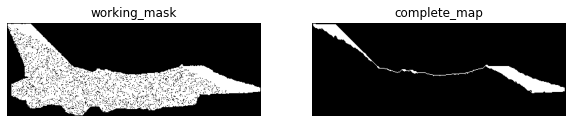

[RecursionError] maximum recursion depth exceeded while calling a Python object Try Again!!


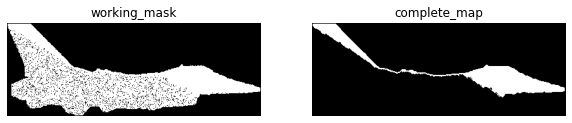

[RecursionError] maximum recursion depth exceeded while calling a Python object Try Again!!


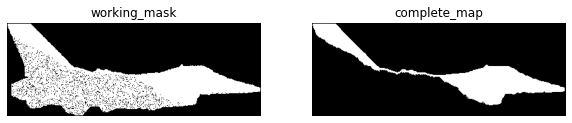

[RecursionError] maximum recursion depth exceeded while calling a Python object Try Again!!


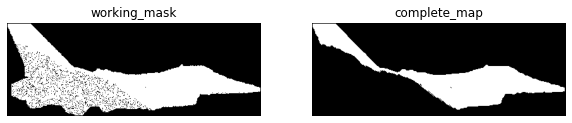

[RecursionError] maximum recursion depth exceeded while calling a Python object Try Again!!


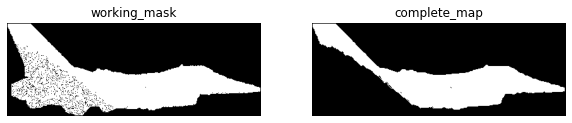

[RecursionError] maximum recursion depth exceeded while calling a Python object Try Again!!


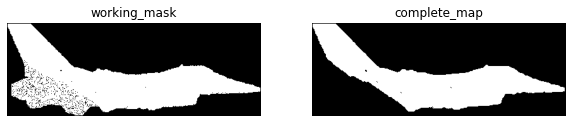

[RecursionError] maximum recursion depth exceeded while calling a Python object Try Again!!


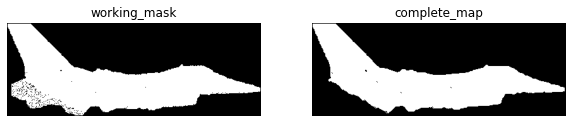

In [10]:
acs = generate_ac(H, W, Sd, t)

tampered_acs = getLowOrder(working_image, (3, eb))
roughly_detected_area = ~(acs == tampered_acs)
roughly_detected_area = (roughly_detected_area[:, :, 0] | roughly_detected_area[:, :, 1] | roughly_detected_area[:, :, 2])

detected_area = FinallyDetect(roughly_detected_area)
detected_size = (detected_area).sum()
unDetected_image = getImageTrueArea(tampered_embedded_image, ~detected_area)

### 1.3 Recovery Image

In [11]:
def getRecoveryCodes(img):
    embedded_rcs = getLowOrder(img, 2)
    real_embedded_rcs = np.zeros((H, W, 3), dtype=np.uint8)
    real_embedded_rcs[:, :, 0] = block4x4rePermutationMechanism(embedded_rcs[:, :, 0], Sd)
    real_embedded_rcs[:, :, 1] = block4x4rePermutationMechanism(embedded_rcs[:, :, 1], Sd)
    real_embedded_rcs[:, :, 2] = block4x4rePermutationMechanism(embedded_rcs[:, :, 2], Sd)
    return real_embedded_rcs

def getUnTamperRecoveryCodes(rePermuted_embedded_rcs, detected_area):
    rePermuted_detected_area = block4x4rePermutationMechanism(detected_area, Sd)
    return decode2nBitBlocks_color_image(rePermuted_embedded_rcs, rePermuted_detected_area)

In [12]:
## Recovery Codes
rcs = getRecoveryCodes(tampered_embedded_image)
rePermuted_embedded_image, rePermuted_embedded_image_mask = getUnTamperRecoveryCodes(rcs, detected_area)
recovery_image = unDetected_image + getImageTrueArea(rePermuted_embedded_image, detected_area)

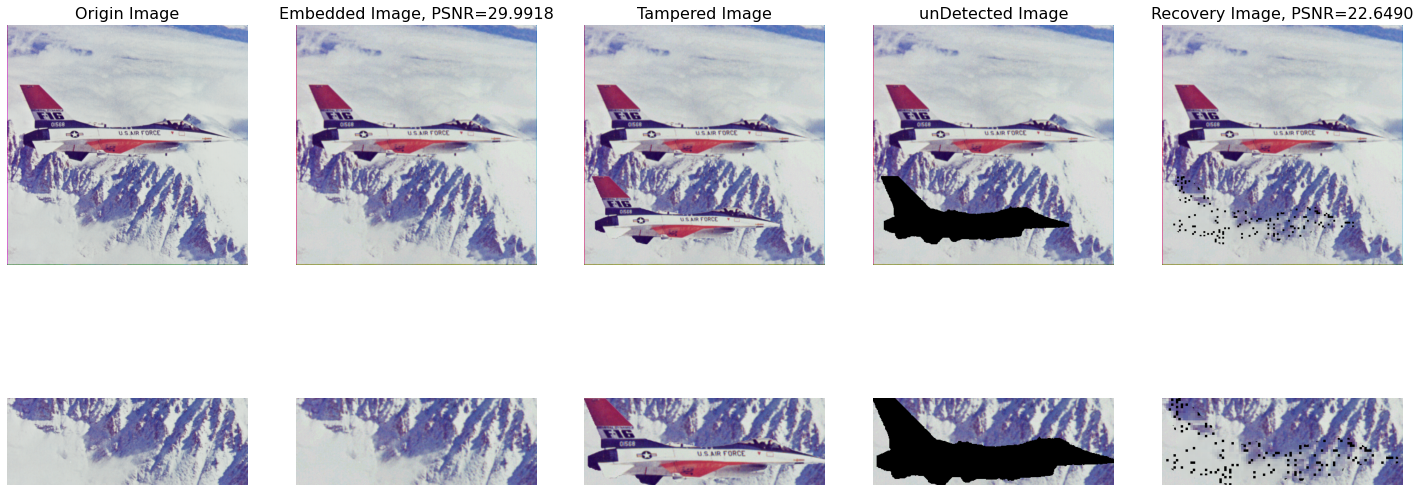

In [13]:
Origin_image = readImg("../_Image Data/圖像集/Jet.tiff")

patch = mask_area_patch(detected_area)
f_size = 16
fig, axs = plt.subplots(2, 5, figsize=(25, 10))
axs[0, 0].set_title("Origin Image", fontsize=f_size)
axs[0, 0].imshow(Origin_image)
axs[0, 0].axis('off')
axs[0, 1].set_title("Embedded Image, PSNR={:.4f}".format(psnr(Origin_image, embedded_image.astype('uint8'))), fontsize=f_size)
axs[0, 1].imshow(embedded_image)
axs[0, 1].axis('off')
axs[0, 2].set_title("Tampered Image", fontsize=f_size)
axs[0, 2].imshow(tampered_embedded_image)
axs[0, 2].axis('off')
axs[0, 3].set_title("unDetected Image", fontsize=f_size)
axs[0, 3].imshow(unDetected_image)
axs[0, 3].axis('off')
axs[0, 4].set_title("Recovery Image, PSNR={:.4f}".format(psnr(Origin_image, recovery_image.astype('uint8'))), fontsize=f_size)
axs[0, 4].imshow(recovery_image)
axs[0, 4].axis('off')
axs[1, 0].imshow(Origin_image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1, 0].axis('off')
axs[1, 1].imshow(embedded_image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1, 1].axis('off')
axs[1, 2].imshow(tampered_embedded_image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1, 2].axis('off')
axs[1, 3].imshow(unDetected_image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1, 3].axis('off')
axs[1, 4].imshow(recovery_image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1, 4].axis('off')
plt.show()

## 2. Inpainting for Image Recovery by exemplar-based

### 2.0 Pre-inpainting Area that unRecovery Area

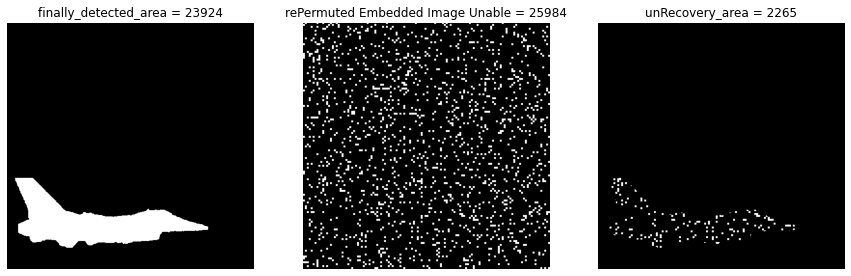

In [14]:
unRecovery_area = rePermuted_embedded_image_mask & detected_area

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(detected_area, cmap="gray")
axs[0].set_title("finally_detected_area = {}".format(detected_area.sum()))
axs[0].axis('off')
axs[1].imshow(rePermuted_embedded_image_mask, cmap="gray")
axs[1].set_title("rePermuted Embedded Image Unable = {}".format(rePermuted_embedded_image_mask.sum()))
axs[1].axis('off')
axs[2].imshow(unRecovery_area, cmap="gray")
axs[2].set_title("unRecovery_area = {}".format(unRecovery_area.sum()))
axs[2].axis('off')

plt.show()

### 2.1 Init

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import scipy
from scipy import ndimage
from tqdm import tqdm
import time
import numpy as np
# import cupy as cp
from skimage import io, color

In [16]:
mask = np.copy(unRecovery_area)

patch_size = (5, 5)

confidence = (1-mask).astype("float32")
data = np.zeros(shape=(H, W))

working_image = np.copy(recovery_image)
working_mask = np.copy(mask)

try:
    del source_patchs
except: 
    pass

### 2.2 Patch

In [17]:
def _patch_data(source, patch):
    return source[
        int(patch[0][0]):int(patch[0][1]+1),
        int(patch[1][0]):int(patch[1][1]+1)
    ]

def _get_patch(point):
    patch = [
        [## Y
            max(0, point[0]-(patch_size[0]-1)//2),
            min(point[0]+(patch_size[0]-1)//2, H-1)
        ],
        [## X
            max(0, point[1]-(patch_size[1]-1)//2),
            min(point[1]+(patch_size[1]-1)//2, W-1)
        ]
    ]

    patch[0][0]-=(patch_size[0]-1-patch[0][1]+patch[0][0]) if patch[0][1] == H-1 else 0
    patch[0][1]+=(patch_size[0]-1-patch[0][1]+patch[0][0]) if patch[0][0] == 0 else 0
    patch[1][0]-=(patch_size[1]-1-patch[1][1]+patch[1][0]) if patch[1][1] == W-1 else 0
    patch[1][1]+=(patch_size[1]-1-patch[1][1]+patch[1][0]) if patch[1][0] == 0 else 0
    
    return patch

### 2.3 Front

In [18]:
def _get_front():
    _front = np.array(scipy.ndimage.laplace(working_mask)>0, np.uint8)
    return _front

### 2.4 Confidence

In [19]:
def _get_confidence(point):
    patch = _get_patch(point)
    patch_confidence = _patch_data(confidence, patch)
    return patch_confidence.sum() / (patch_confidence.shape[0]*patch_confidence.shape[1])

def _update_confidence(confidence):
    new_confidence = np.copy(confidence)
    for point in front_positions:
        new_confidence[point[0], point[1]] = _get_confidence(point)
    confidence = new_confidence
    return confidence

### 2.5 Data

In [20]:
def _update_data(working_image, working_mask, front):
    normal = _calc_normal_matrix(working_mask)    
    gradient = _calc_gradient_matrix(working_image, working_mask, front)
    normal_gradient = normal*gradient
    
    data = np.sqrt(normal_gradient[:, :, 0]**2 + normal_gradient[:, :, 1]**2) + 0.001
    return data
    
def _calc_normal_matrix(working_mask):
    x_kernal = np.array([
        [.25, 0, -.25],
        [.5, 0, -.5],
        [.25, 0, -.25],
    ])
    y_kernal = np.array([
        [-.25, -.5, -.25],
        [0, 0, 0],
        [.25, .5, .25],
    ])
    
    x_normal = scipy.ndimage.convolve(working_mask.astype('float64'), x_kernal)
    y_normal = scipy.ndimage.convolve(working_mask.astype('float64'), y_kernal)
    normal = np.dstack((x_normal, y_normal))
    
    height, width = normal.shape[:2]
    norm = np.sqrt(y_normal**2 + x_normal**2) \
        .reshape(height, width, 1) \
        .repeat(2, axis=2)
    norm[norm == 0] = 1
    unit_normal = normal/norm
    return unit_normal
    
def _calc_gradient_matrix(working_image, working_mask, front):
    height, width = working_image.shape[:2]    
    gray_image = color.rgb2gray(working_image)
    gray_image[working_mask == 1] = None
    gradient = np.nan_to_num(np.array(np.gradient(gray_image)))

    gradient_val = np.sqrt(gradient[0]**2 + gradient[1]**2)
    max_gradient = np.zeros([height, width, 2])
    
    front_positions = np.argwhere(front == 1)
    for point in front_positions:
        patch = _get_patch(point)
        patch_y_gradient = _patch_data(gradient[0], patch)
        patch_x_gradient = _patch_data(gradient[1], patch)
        patch_gradient_val = _patch_data(gradient_val, patch)
        
        patch_max_pos = np.unravel_index(
            patch_gradient_val.argmax(),
            patch_gradient_val.shape
        )
        
        max_gradient[point[0], point[1], 0] = patch_y_gradient[patch_max_pos]
        max_gradient[point[0], point[1], 1] = patch_x_gradient[patch_max_pos]
    
    return max_gradient

### 2.6 Priority
$ Priority = Confidence*Data*Front $

In [21]:
def _update_priority(working_image, working_mask, confidence, front):
    confidence = _update_confidence(confidence)
    data = _update_data(working_image, working_mask, front)
    priority = confidence*data*front

    return priority

### 2.7 Highest Priority Patch

In [22]:
def _find_highest_priority_pixel(priority):
    point = np.unravel_index(
        priority.argmax(),
        priority.shape
    )
    
    return point

### 2.8 exemplar-based Compared

In [23]:
def _to_rgb(image):
    height, width = image.shape
    return image.reshape(height, width, 1).repeat(3, axis=2)

def ELIG_patch_list(source, patch_list):
    eligible_patch_list = np.array([
        patch
        for patch in patch_list
        if _patch_data(source, patch).sum() == 0
    ], dtype=np.int64)
    return eligible_patch_list

def _patch_list(height, width, patch_height, patch_width, base_height=0, base_width=0):
    for y in range(base_height, base_height+height-patch_height+1):
        for x in range(base_width, base_width+width-patch_width+1):
            yield [y, y+patch_height-1], [x, x+patch_width-1]

In [24]:
def update_elig(lab_image, associate_patch, patchs, patchs_data):
    elig = np.array(ELIG_patch_list(
        working_mask,
        _patch_list(
            associate_patch[0][1] - associate_patch[0][0], 
            associate_patch[1][1] - associate_patch[1][0], 
            patch_size[0], patch_size[1], 
            base_height=associate_patch[0][0]+1, 
            base_width=associate_patch[1][0]+1
        )
    ))

    if elig.size > 0:
        # ### GPU
        # patchs = cp.concatenate([cp.array(elig), patchs])
        # patchs_data = cp.concatenate([cp.array([_patch_data(lab_image, patch) for patch in elig]), patchs_data])
        patchs = np.concatenate([elig, patchs])
        patchs_data = np.concatenate([[_patch_data(lab_image, patch) for patch in elig], patchs_data])
    return patchs, patchs_data

### 2.9 Inpainting

In [25]:
def _update_image(target_pixel, source_patch):
    target_patch = _get_patch(target_pixel)
    pixels_positions = np.argwhere(
        _patch_data(working_mask, target_patch) == 1
    ) + [target_patch[0][0], target_patch[1][0]]
    patch_confidences = confidence[target_pixel[0], target_pixel[1]]
    for point in pixels_positions:
        confidence[point[0], point[1]] = patch_confidences
    mask = _patch_data(working_mask, target_patch)
    rgb_mask = _to_rgb(mask)
    source_data = _patch_data(working_image, source_patch)
    target_data = _patch_data(working_image, target_patch)

    new_data = source_data*rgb_mask + target_data*(1-rgb_mask)

    _copy_to_patch(
        working_image,
        target_patch,
        new_data
    )

    _copy_to_patch(
        working_mask,
        target_patch,
        0
    )

def _copy_to_patch(dest, dest_patch, data):
    dest[
        dest_patch[0][0]:dest_patch[0][1]+1,
        dest_patch[1][0]:dest_patch[1][1]+1
    ] = data

### 2.10 Start Working

In [26]:
from celluloid import Camera

try:
    itera
    timer
except NameError:
    itera = 0
    timer = []

# itera = 0
# timer = []

while(True):
    mask_sum = working_mask.sum()
    if mask_sum == 0:
        break;

    start_time = time.time()

    ## 修補的外框
    front = _get_front()
    front_positions = np.argwhere(front == 1)

    ## 尋找最高優先度的修補點
    priority = _update_priority(
        working_image, working_mask, confidence, front
    )
    target_pixel = _find_highest_priority_pixel(priority)

    ## 取得被修補區塊範圍(patch)
    target_patch = _get_patch(target_pixel)

    ## 目前image的lab圖
    lab_image = color.rgb2lab(working_image)

    ## 被修補區塊中不該被修補的部分(陣列中為1的部分)
    mask = 1-_patch_data(working_mask, target_patch)
    rgb_mask = _to_rgb(mask)
    ### GPU
    # rgb_mask = cp.array(_to_rgb(mask))

    ## 整張圖片中被考慮替換掉 被修補區塊的 範圍list及lab範圍值
    try:
        source_patchs
    except NameError:
        source_patchs = ELIG_patch_list(working_mask, _patch_list(H, W, patch_size[0], patch_size[1]))
        lab_image_source_patchs_data = [_patch_data(lab_image, patch) for patch in source_patchs]
        # ### GPU
        # source_patchs = cp.array(source_patchs)
        # lab_image_source_patchs_data = cp.array(lab_image_source_patchs_data)

    ## 被修補區塊的lab範圍值 
    ### GPU
    # target_patch_data = cp.array(_patch_data(lab_image, target_patch))*rgb_mask
    target_patch_data = _patch_data(lab_image, target_patch)*rgb_mask

    ## 計算值差
    squared_distance = ((target_patch_data - lab_image_source_patchs_data*rgb_mask)**2).sum(axis=(3, 2, 1))
    euclidean_distance = np.sqrt(
        (target_patch[0][0] - source_patchs[:, 0, 0])**2 +
        (target_patch[1][0] - source_patchs[:, 1, 0])**2
    )
    diff = squared_distance + euclidean_distance

    ## 與被修補區塊的lab範圍值的差值最小 以及 距離最近的範圍
    mix_source_index = diff.argmin()
    source_patch = np.copy(source_patchs[mix_source_index])

    # 帶修補區域中 未來會會加入source_patchs的範圍
    ## 帶修補區域中要被替換掉的值索引
    associate_pos = np.argwhere(
        _patch_data(working_mask, target_patch) == 1
    )

    ## 最左上的點
    min_patch_pos = min(associate_pos[:, 0])+target_patch[0][0], min(associate_pos[:, 1])+target_patch[1][0]
    ## 會影響到同樣patch_size的範圍，這裡為修補過後應該加入的範圍
    associate_patch = [
        [max(min_patch_pos[0]-patch_size[0]+1, 0), min_patch_pos[0]+(max(associate_pos[:, 0])-min(associate_pos[:, 0]))],
        [max(min_patch_pos[1]-patch_size[1]+1, 0), min_patch_pos[1]+(max(associate_pos[:, 1])-min(associate_pos[:, 1]))]
    ]

    ## 開始對 被修補區塊 進行替換
    try:
        _update_image(target_pixel, source_patch)
    except:
        # print("[Error Message]", e)
        print("target_pixel", target_pixel)
        print("source_patch", source_patch)
        break

    ## 把因為修補後所產生的那些 也該被考量在與target_patch範圍 加入倒source_patchs 及 lab_image_source_patchs_data
    source_patchs, lab_image_source_patchs_data = update_elig(lab_image, associate_patch, source_patchs, lab_image_source_patchs_data)

    ## 畫面紀錄
    end_time = time.time()
    timer.append(end_time-start_time)
    itera += 1
    print("Iter: {}, sRuntime: {}, nowMask: {}".format(itera, end_time-start_time, mask_sum))

Iter: 1, sRuntime: 3.847311496734619, nowMask: 2265
Iter: 2, sRuntime: 0.5230393409729004, nowMask: 2259
Iter: 3, sRuntime: 0.5279984474182129, nowMask: 2253
Iter: 4, sRuntime: 0.5269999504089355, nowMask: 2245
Iter: 5, sRuntime: 0.43700456619262695, nowMask: 2239
Iter: 6, sRuntime: 0.43599939346313477, nowMask: 2235
Iter: 7, sRuntime: 0.43996667861938477, nowMask: 2233
Iter: 8, sRuntime: 0.4479944705963135, nowMask: 2231
Iter: 9, sRuntime: 0.46892619132995605, nowMask: 2225
Iter: 10, sRuntime: 0.48500633239746094, nowMask: 2221
Iter: 11, sRuntime: 0.42704057693481445, nowMask: 2215
Iter: 12, sRuntime: 0.44396233558654785, nowMask: 2209
Iter: 13, sRuntime: 0.49999308586120605, nowMask: 2203
Iter: 14, sRuntime: 0.5371155738830566, nowMask: 2197
Iter: 15, sRuntime: 0.4836721420288086, nowMask: 2189
Iter: 16, sRuntime: 0.4919884204864502, nowMask: 2183
Iter: 17, sRuntime: 0.515000581741333, nowMask: 2175
Iter: 18, sRuntime: 0.48799777030944824, nowMask: 2169
Iter: 19, sRuntime: 0.47999930

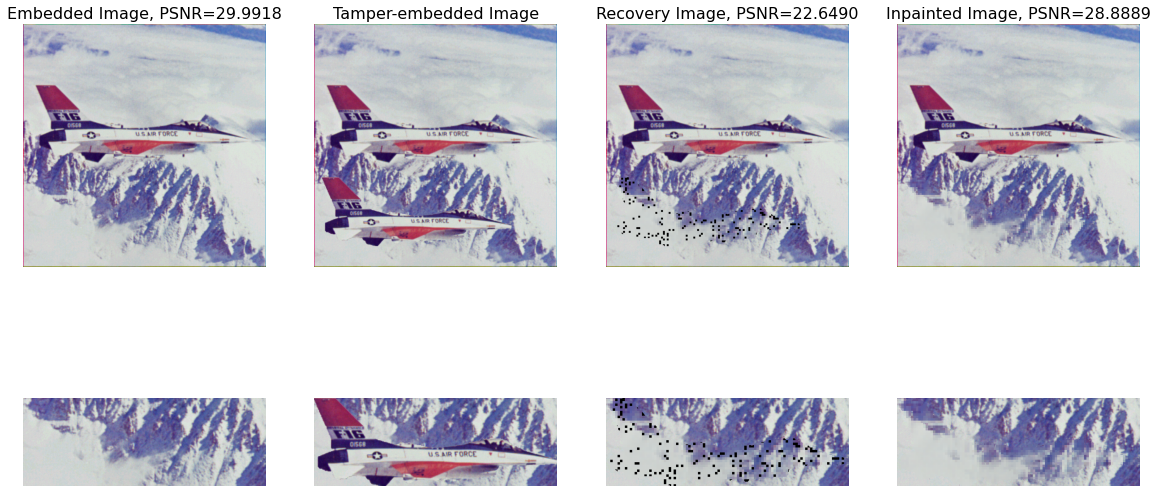

In [27]:
f_size = 16
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs[0, 0].imshow(embedded_image)
axs[0, 0].set_title("Embedded Image, PSNR={:.4f}".format(psnr(Origin_image, embedded_image.astype('uint8'))), fontsize=f_size)
axs[0, 0].axis('off')
axs[0, 1].imshow(tampered_embedded_image)
axs[0, 1].set_title("Tamper-embedded Image", fontsize=f_size)
axs[0, 1].axis('off')
axs[0, 2].imshow(recovery_image)
axs[0, 2].set_title("Recovery Image, PSNR={:.4f}".format(psnr(Origin_image, recovery_image.astype('uint8'))), fontsize=f_size)
axs[0, 2].axis('off')
axs[0, 3].imshow(working_image)
axs[0, 3].set_title("Inpainted Image, PSNR={:.4f}".format(psnr(Origin_image, working_image.astype('uint8'))), fontsize=f_size)
axs[0, 3].axis('off')

axs[1, 0].imshow(embedded_image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1, 0].axis('off')
axs[1, 1].imshow(tampered_embedded_image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1, 1].axis('off')
axs[1, 2].imshow(recovery_image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1, 2].axis('off')
axs[1, 3].imshow(working_image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1, 3].axis('off')
plt.show()

In [28]:
import yaml
import datetime
import pathlib
import pprint

file_path = pathlib.Path(tampered_embedded_image_path)
new_file_path = "./img/output/{}_inpainted=1{}".format(file_path.stem, file_path.suffix)


recovery_file_path = "./img/output/{}_recovery{}".format(file_path.stem, file_path.suffix)


log = dict(
    Title = 'Inpainting 1. output history',
    Time = datetime.datetime.now(),
    Source = tampered_embedded_image_path,
    Output = new_file_path,
    Recovery_PSNR = psnr(Origin_image, recovery_image.astype('uint8')),
    Inpainted_PSNR =  psnr(Origin_image, working_image.astype('uint8')),
    Detected_area = detected_area.sum().item(),
    unRecovery_area = unRecovery_area.sum().item()
)

pprint.pprint(log)

{'Detected_area': 23924,
 'Inpainted_PSNR': 28.88889158485327,
 'Output': './img/output/lena_embedded_eb=3_tp=1_inpainted=1.png',
 'Recovery_PSNR': 22.648970944415773,
 'Source': './img/output/lena_embedded_eb=3_tp=1.png',
 'Time': datetime.datetime(2022, 4, 30, 17, 38, 18, 549103),
 'Title': 'Inpainting 1. output history',
 'unRecovery_area': 2265}


In [29]:
## save image
imageio.imwrite(new_file_path, working_image)
imageio.imwrite(recovery_file_path, recovery_image)

## save log
with open('./img/output/{}_inpainted=1_log.yml'.format(file_path.stem), 'w') as outfile:
    yaml.dump(log, outfile, default_flow_style=False)

### TODO: 將修補方式改變
1. Image AMBTC block by recovery codes 不直接進行替換，而是直接開始使用inpainting
2. 將AMBTC block當作對比權重，納入inpainting中當尋找相似block的要素
3. 如果該塊沒有權重(AMBTC被破壞)，則最後再進行修補